In [1]:
import cortex
import cortex.polyutils
import sys
import numpy as np
sys.path.append('/Users/mayra/PycharmProjects/CFM_RS_validation')
from helper_functions import readVerts
# from bold_preproc import *
import yaml
import os
opj = os.path.join
from prfpy.fit import Iso2DGaussianFitter, Fitter, Extend_Iso2DGaussianFitter
import neuropythy
from neuropythy import as_retinotopy
from matplotlib import cm
import matplotlib.colors as mcolors

In [2]:
print(cortex.__version__)
cortex.database.default_filestore

1.2.6


'/Users/mayra/opt/anaconda3/share/pycortex/db'

In [3]:
subjectid='sub-001'
subject = 'sub-001'
atlas = 'benson'
depth='GM'
project='CFLamUp'
denoising='nordic_sm4'
MAIN_PATH=f'/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/{project}/derivatives'
model_name='gauss_fitter'
space='fsnative'
roi=['all']
r2_thr=0
plot_corrL4=0
# %%
# In order to get the number of vertices in this subject's cortical surface
# we have to load in their surfaces and get the number of points in each
surfs = [cortex.polyutils.Surface(*d)
         for d in cortex.db.get_surf(subject, "fiducial")]

# First we need to import the surfaces for this subject
numel_left = surfs[0].pts.shape[0]
numel_right = surfs[1].pts.shape[0]
numel = numel_left + numel_right

In [4]:
if subject=='fsaverage':
    fs_dirPATH='/Volumes/May_fMRI/Inzicht_CFM/derivatives/freesurfer'
else:
    fs_dirPATH=f'{MAIN_PATH}/freesurfer'

idx_rois1, idx_vls1 = cortex.freesurfer.get_label(subject, label='benson14_eccen-0001',
    fs_dir=fs_dirPATH,
    hemisphere=('lh', 'rh'),
    verbose=True)
idx_rois2, idx_vls2 = cortex.freesurfer.get_label(subject, label='benson14_angle-0001',
   fs_dir=fs_dirPATH,
  hemisphere=('lh', 'rh'),
  verbose=True)
idx_rois3, idx_vls3 = cortex.freesurfer.get_label(subject, label='benson14_sigma-0001',
   fs_dir=fs_dirPATH,
  hemisphere=('lh', 'rh'),
  verbose=True)
idx_rois4, idx_vls4 = cortex.freesurfer.get_label(subject, label='benson14_varea-0001',
   fs_dir=fs_dirPATH,
  hemisphere=('lh', 'rh'),
  verbose=True)

if atlas=='manual':
    idx_rois5, idx_vls5 = cortex.freesurfer.get_label(subject, label='manualdelin',
       fs_dir=fs_dirPATH,
      hemisphere=('lh','rh'),
      verbose=True)
    idx_vls4[idx_rois5]=idx_vls5
#convert polar angle from 'visual' to 'standard' style (see https://github.com/noahbenson/neuropythy/wiki/Retinotopy#conversion for more information)
idx_vls2[numel_left:]=-idx_vls2[numel_left:]
data=(idx_vls2,idx_vls1)
data=as_retinotopy(data, output_style='standard')
idx_vls2=data[0][:]

looking for ['/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-001/label/lh.benson14_eccen-0001.label', '/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-001/label/rh.benson14_eccen-0001.label']
looking for ['/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-001/label/lh.benson14_angle-0001.label', '/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-001/label/rh.benson14_angle-0001.label']
looking for ['/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-001/label/lh.benson14_sigma-0001.label', '/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-001/label/rh.benson14_sigma-0001.label']
looking for ['/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-001/label/lh.benson14_varea-0001.label', '/Users/mayra/Lib

In [5]:
#plot Benson atlas
rois_list = []
rois_list = np.array([['V1', 'V2', 'V3', 'LO1', 'LO2','V3a','V3b','V4'], [1, 2, 3, 7, 8,11,12,4]])
rois = ['V1', 'V2', 'V3', 'LO1', 'LO2','V3a','V3b','V4']

#plot trial averaged r2
ecc_map = cortex.Vertex.empty(subject)
ecc_map.data[:] = 90
angle_map = cortex.Vertex.empty(subject)
angle_map.data[:] = 0
sigma_map = cortex.Vertex.empty(subject)
sigma_map.data[:] = 0
varea_map = cortex.Vertex.empty(subject)
varea_map.data[:] = 0

#newcmap=make_polar_cmap()
for r in range(rois.__len__()):
    roi_idx = np.where(rois[r] == rois_list[0, :])
    roi_verts = np.array(np.where(idx_vls4 == int(rois_list[1, roi_idx])))[0]
    varea_map.data[roi_verts] = r + 2
    ecc_map.data[roi_verts] = idx_vls1[roi_verts]
    angle_map.data[roi_verts] = idx_vls2[roi_verts]
    sigma_map.data[roi_verts] = idx_vls3[roi_verts]

# ecc_map.data = idx_vls1
# angle_map.data = idx_vls2
# sigma_map.data[:]=idx_vls3
# varea_map.data[:]=idx_vls4

data_ecc = cortex.Vertex(data=ecc_map.data, subject=subject, vmin=0, vmax=5, cmap='jet_r')
data_angle = cortex.Vertex(data=angle_map.data, subject=subject, vmin=-3.14, vmax=3.14, cmap='hsv')
data_sigma = cortex.Vertex(data=sigma_map.data, subject=subject, vmin=0, vmax=20, cmap='jet_r')
data_varea = cortex.Vertex(data=varea_map.data, subject=subject, cmap='jet', vmin=0, vmax=r + 2)

In [6]:
#plot fit results
import pickle
if rois[0].__len__()>1:
    test_file=opj(f'{MAIN_PATH}/pRFM/{subject}/ses-1/{denoising}/', f'model-{atlas}-{model_name}-{depth}_desc-prf_params.pkl')
else:
    test_file=opj(f'{MAIN_PATH}/pRFM/{subject}/ses-1/{denoising}/', f'roi-{roi[0]}_model-{atlas}-{model_name}-{depth}_desc-prf_params.pkl')
with open(test_file, 'rb') as input:
    pkl_data = pickle.load(input)
prf_params=pkl_data['model'].iterative_search_params
#prf_params_vx=pkl_data['roi_verts']
roi_verts=np.where(pkl_data['rois_mask']==1)
prf_params_vx=roi_verts[0]

import scipy
if plot_corrL4==1:
    if rois[0].__len__()>1:
        test_file=opj(f'{MAIN_PATH}/pRFM/{subject}/ses-1/{denoising}/', f'model-{atlas}-{model_name}-{model_name}_desc-tc_corr.pkl')
    else:
        test_file=opj(f'{MAIN_PATH}/pRFM/{subject}/ses-1/{denoising}/', f'roi-{rois[0]}_model-{atlas}-{model_name}_desc-tc_corr.pkl')
    with open(test_file, 'rb') as input:
        pkl_data2 = pickle.load(input)
    tcs_layers=pkl_data2['tcs_layers']
    #calculate correlation between layers sup and 4
    corr_vx_SxL4=np.arange(tcs_layers[0].shape[0], dtype='float16')
    corr_vx_SxD=np.arange(tcs_layers[0].shape[0], dtype='float16')
    corr_vx_L4xD=np.arange(tcs_layers[0].shape[0], dtype='float16')
    p_vx=np.arange(tcs_layers[0].shape[0],dtype='float16')
    for vx in range(tcs_layers[0].shape[0]):
        corr_vx_SxL4[vx], p_vx[vx]=scipy.stats.spearmanr(tcs_layers[1][vx,:],tcs_layers[2][vx,:], axis=1)
        corr_vx_SxD[vx], p_vx[vx]=scipy.stats.spearmanr(tcs_layers[1][vx,:],tcs_layers[3][vx,:], axis=1)
        corr_vx_L4xD[vx], p_vx[vx]=scipy.stats.spearmanr(tcs_layers[2][vx,:],tcs_layers[3][vx,:], axis=1)


/Users/mayra/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


Min rsq = 0.011
Mean rsq = 0.227
Max rsq = 0.758
(array([11537]),)


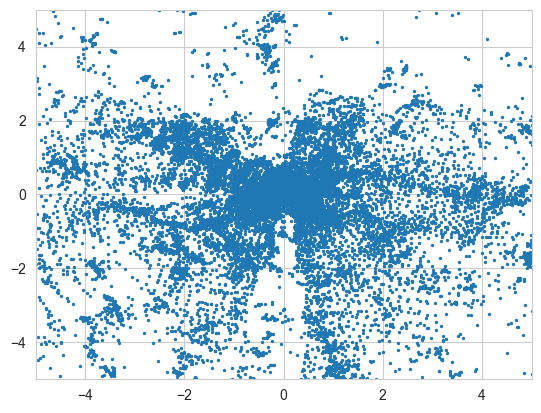

Mean r2= 0.227
Min r2= 0.011
Max r2= 0.758


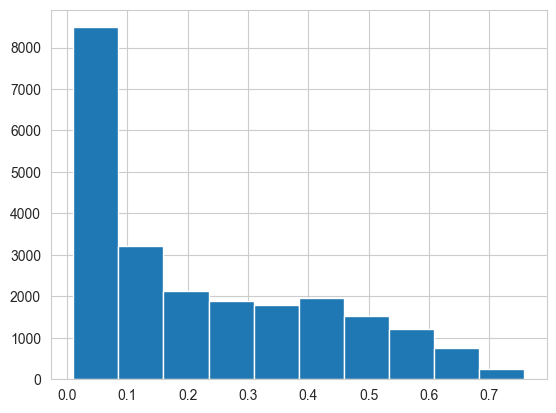

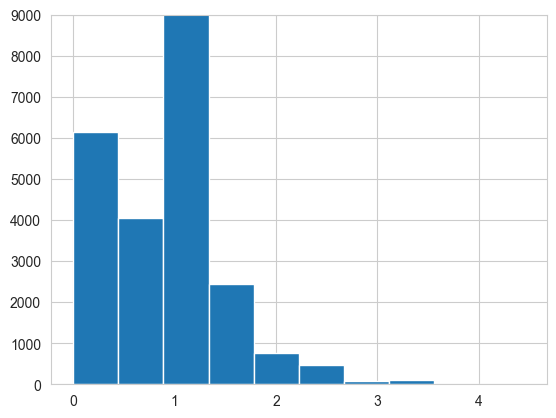

Best vx hrf_deriv= 10.000
Best vx size= 0.936
Best vx r2 no_hrf_grid= 0.748
Best vx r2 no_hrf_iter= 0.758
Best vx r2 iter= 0.758
Nvx = 23211 out of 23244, 99.9%


In [7]:
import matplotlib.pyplot as plt
gauss_fitter=pkl_data['model']
print(f'Min rsq = {np.nanmin(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask!=0,-1]):.3f}')
print(f'Mean rsq = {np.nanmean(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask>0,-1]):.3f}')
print(f'Max rsq = {gauss_fitter.iterative_search_params[:,-1].max():.3f}')
print(np.where(gauss_fitter.iterative_search_params[:,-1]==gauss_fitter.iterative_search_params[:,-1].max()))
best_vx=np.where(gauss_fitter.iterative_search_params[:,-1]==gauss_fitter.iterative_search_params[:,-1].max())

# Plot the location...
plt.scatter(gauss_fitter.iterative_search_params[:,0], gauss_fitter.iterative_search_params[:,1],marker='o', s=2)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()
print(f'Mean r2= {np.nanmean(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask!=0,7]):.3f}')
print(f'Min r2= {np.min(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask==1,7]):.3f}')
print(f'Max r2= {np.max(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask!=0,7]):.3f}')
plt.hist(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask!=0,7])
#plt.hist(gauss_fitter.iterative_search_params[:,7])
#plt.xlim(0,0.8)
#plt.ylim(0,9000)
plt.show()
plt.hist(gauss_fitter.iterative_search_params[:,2])
plt.ylim(0,9000)
plt.show()
print(f'Best vx hrf_deriv= {gauss_fitter.iterative_search_params[int(best_vx[0]),-3]:.3f}')
print(f'Best vx size= {gauss_fitter.iterative_search_params[int(best_vx[0]),2]:.3f}')
print(f'Best vx r2 no_hrf_grid= {gauss_fitter.gridsearch_params[int(best_vx[0]),-1]:.3f}')
print(f'Best vx r2 no_hrf_iter= {gauss_fitter.iterative_search_params[int(best_vx[0]),-1]:.3f}')
print(f'Best vx r2 iter= {gauss_fitter.iterative_search_params[int(best_vx[0]),-1]:.3f}')

# Rescue vxs where iterative fit was worse than grid fit
rsq_mask=np.ones(gauss_fitter.rsq_mask.shape) #this one is based on grid fit
rsq_mask[gauss_fitter.iterative_search_params[:,7]<r2_thr]=False
print(f'Nvx = {np.count_nonzero(gauss_fitter.rsq_mask)} out of {rsq_mask.shape[0]}, {np.count_nonzero(gauss_fitter.rsq_mask)/rsq_mask.shape[0]*100:.1f}%')

In [8]:
# prf_params = np.load(f'./pilot1-fsnativeWNORDIC/slow_fit/prf_params.npy')
# prf_params_vx = np.load(f'./pilot1-fsnativeWNORDIC/slow_fit/psc_avg_ts_vx.npy')

# prf_params = np.load(f'./pRFM/sub-002/fsnative/prf_params.npy')
# prf_params_vx = np.load(f'./pRFM/sub-002/fsnative/psc_avg_ts_vx.npy')
ecc_mapFit = cortex.Vertex.empty(subject)
ecc_mapFit.data[:] = 90
angle_mapFit = cortex.Vertex.empty(subject)
angle_mapFit.data[:] = 0
sigma_mapFit = cortex.Vertex.empty(subject)
sigma_mapFit.data[:] = 0
r2_mapFit = cortex.Vertex.empty(subject)
r2_mapFit.data[:] = 0
corr_SxL4_mapFit = cortex.Vertex.empty(subject)
corr_SxL4_mapFit.data[:] = -1
corr_SxD_mapFit = cortex.Vertex.empty(subject)
corr_SxD_mapFit.data[:] = -1
corr_L4xD_mapFit = cortex.Vertex.empty(subject)
corr_L4xD_mapFit.data[:] = -1

for vx in range(prf_params_vx.__len__()):
    if (prf_params[vx,7]>r2_thr):
        ecc_mapFit.data[int(prf_params_vx[vx])] = np.sqrt(prf_params[vx,1]**2+prf_params[vx,0]**2)
        angle_mapFit.data[int(prf_params_vx[vx])] = np.arctan2(prf_params[vx,1],prf_params[vx,0])
        sigma_mapFit.data[int(prf_params_vx[vx])] = prf_params[vx,2]
        r2_mapFit.data[int(prf_params_vx[vx])] = prf_params[vx,7]
        # corr_SxL4_mapFit.data[int(prf_params_vx[vx])] = corr_vx_SxL4[vx]
        # corr_SxD_mapFit.data[int(prf_params_vx[vx])] = corr_vx_SxD[vx]
        # corr_L4xD_mapFit.data[int(prf_params_vx[vx])] = corr_vx_L4xD[vx]

# for r in range(rois.__len__()):
#     roi_idx = np.where(rois[r] == rois_list[0, :])
#     roi_verts = np.array(np.where(idx_vls4 == int(rois_list[1, roi_idx])))[0]
#     ecc_mapFit.data[roi_verts] = np.sqrt(prf_params[roi_verts,1]**2+prf_params[roi_verts,0]**2)
#     angle_mapFit.data[roi_verts] = np.rad2deg(np.arctan2(prf_params[roi_verts,1],prf_params[roi_verts,0]))
#     sigma_mapFit.data[roi_verts] = prf_params[roi_verts,2]
#     r2_mapFit.data[roi_verts] = prf_params[roi_verts,7]

#adjust angle according to benson scale?
data_eccFit = cortex.Vertex(data=ecc_mapFit.data, subject=subject, vmin=0, vmax=5, cmap='jet_r', with_curvature=True)
data_angleFit = cortex.Vertex(data=angle_mapFit.data, subject=subject, vmin=-3.14, vmax=3.14, cmap='hsv')
data_sigmaFit = cortex.Vertex(data=sigma_mapFit.data, subject=subject, vmin=0, vmax=20, cmap='jet')
data_r2Fit = cortex.Vertex(data=r2_mapFit.data, subject=subject, cmap='jet', vmin=0.01, vmax=0.8)
# data_corr_SxL4Fit = cortex.Vertex(data=corr_SxL4_mapFit.data, subject=subject, cmap='jet', vmin=0, vmax=1)
# data_corr_SxDFit = cortex.Vertex(data=corr_SxD_mapFit.data, subject=subject, cmap='jet', vmin=0, vmax=1)
# data_corr_L4xDFit = cortex.Vertex(data=corr_L4xD_mapFit.data, subject=subject, cmap='jet', vmin=0, vmax=1)

#gather multiple datasets
datasets = {'Benson_2014-varea': data_varea,'Benson_2014-Ecc': data_ecc, 'pRFfit-Ecc': data_eccFit, 'pRFfit-r2': data_r2Fit, 'Benson_2014-Angle': data_angle,'pRFfit-Angle': data_angleFit,
            'Benson_2014-Sigma': data_sigma, 'pRFfit-Sigma': data_sigmaFit} #,'tcCorr-SxL4': data_corr_SxL4Fit, 'tcCorr-SxD': data_corr_SxDFit,'tcCorr-L4xD': data_corr_L4xDFit,}

cortex.webgl.show(data=datasets, recache=True, labels_visible=(),title=f'pRF-fsnative{depth}')

Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 14996


<JS: window.viewer>

In [9]:
#map.data[:] = np.arctan2(prf_params[:,1],prf_params[:,0]) #polar angle
#map.data[:] = np.sqrt(prf_params[:,1]**2+prf_params[:,0]**2) #ecc
#basic_plot(map.data,subject='fsaverage',vmin=-0,vmax=1)
#map.data[:] = prf_params[:,7] #r2

# basic_plot(map.data,subject='fsaverage',vmin=0,vmax=1)
#cortex.webgl.show(data=map,recache=True,labels_visible=(),title=subjectid)

In [39]:
roi_idx = np.where(rois[0] == rois_list[0, :])
idx_vls4[np.int32(prf_params_vx)].shape
roi_verts = np.array(np.where(idx_vls4[np.int32(prf_params_vx)] == int(rois_list[1, roi_idx])))[0]

In [40]:
ecc=np.sqrt(prf_params[roi_verts,1]**2+prf_params[roi_verts,0]**2)
sigma=prf_params[roi_verts,2]

Text(0, 0.5, 'pRF-size')

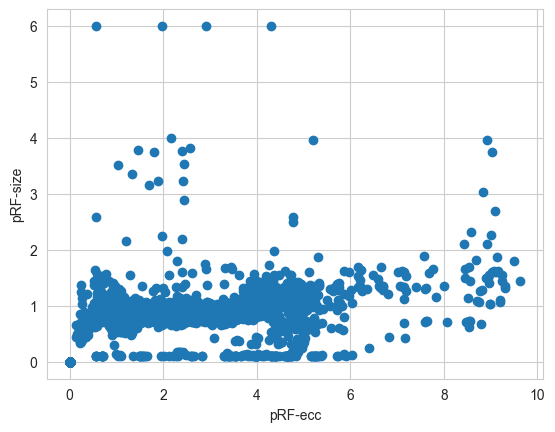

In [41]:
# map.data[:] = np.arctan2(prf_params[:,1],prf_params[:,0]) #polar angle
import matplotlib.pyplot as plt

#plt.scatter(filt_prf_params[:,2],ecc_mapFit.data[prf_params[:,7]>0.09])
plt.scatter(ecc,sigma)
plt.xlabel('pRF-ecc')
plt.ylabel('pRF-size')

In [42]:
def basic_plot(dat,vmax,subject='fsaverage',vmin=0,rois=False,colorbar=False,cmap='jet',ax=None):
    light=cortex.Vertex(dat,subject=subject, vmin=vmin, vmax=vmax,cmap=cmap)
    mfig=cortex.quickshow(light,with_curvature=True,with_rois=rois,with_colorbar=colorbar,fig=ax)

In [43]:
def make_polar_cmap():
    top = cm.get_cmap('hsv', 256)
    bottom = cm.get_cmap('hsv', 256)

    newcolors = np.vstack((top(np.linspace(0, 1, 256)), bottom(np.linspace(0, 1, 256))))
    cmap = mcolors.ListedColormap(newcolors, name='hsvx2')

    return cmap

In [44]:
# vsRH=759
# vsLH=638
# vtRH=212
# vtLH=196